# Q1.6: Revised Team 22 Project

### Comments received
1.You may consider using geographical features to differentiate the carparks from each other.
Also, instead of using one ML model per carpark, we would recommend to use one model for all carparks.

2.The “web/phone application or integration with established wayfinding applications” is interesting and a good purpose, but it does not suit the theme of this module as much as doing data analysis. Do allocate your time and resources wisely if your team decide to do this.

### Revision of project
Having internalised the comments, we have decided to use a model for all carparks. By comparing 3 models, we will use the final selected model to predict


In [3]:
import pandas as pd
import numpy as np

# Data cleaning and preparation

We start by loading data from July to September 2022.

In [4]:
def load_data(month, days=31):
    full_df = pd.read_csv(f"./data/2022-{str(month)}-1.csv")
    for date in range(2, days+1):
        test_df = pd.read_csv(f'./data/2022-{str(month)}-{date}.csv')
        full_df = pd.concat([full_df, test_df])
    full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
    full_df = full_df.set_index('timestamp')
    return full_df

In [5]:
jul = load_data(7)
aug = load_data(8)
sep = load_data(9, days=30)
full_data = pd.concat([jul, aug, sep])
full_data.dropna(inplace=True)

In [6]:
full_data['available rate'] = full_data['lots_available'] / full_data['total_lots']
full_data.dropna(inplace=True)
grped_full = full_data.groupby(full_data.carpark_number)

For each carpark, we use the first 70% as training data and last 30% as testing data. We will use previous 8*24 hours availability as features to predict the next 24 hours availability.
We slice out the data for each carpark and resample them to fill in missing values. Then we prepare training and testing features and labels.

In [7]:
# helper method to create inputs and outputs from a given dataset
def prep_train_test(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)-24):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i:i+24].values)
        # if np.isnan(X[-1]).any():
        #     print(X[-1])
        # if np.isnan(Y[-1]).any():
        #     print(Y[-1])
    return X, Y

In [8]:
carparks = grped_full.carpark_number.unique()
print(carparks)
trainX, trainY = [], []
testX, testY = [], []
feature_len = 24*8
split = 0.3
print("total ids:", len(carparks))
index = 0
for id in carparks:
    slice = grped_full.get_group(id[0])
    slice = slice.resample('1h').mean()
    if slice.shape[0] != 2208:
        print(slice.shape[0])
        print("Lossy data. Dropped")
        continue
    if slice.isnull().values.any():
        slice.fillna(method='ffill', inplace=True)
    split_index = int(slice.shape[0] * split)
    X_train1, Y_train1 = prep_train_test(slice[:split_index], feature_len)
    X_test1, Y_test1 = prep_train_test(slice[split_index:], feature_len)
    trainX.extend(X_train1)
    trainY.extend(Y_train1)
    testX.extend(X_test1)
    testY.extend(Y_test1)
    index += 1
    if index % 100 == 0:
        print(index, "done")
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
testY = np.array(testY)


carpark_number
A10      [A10]
A100    [A100]
A11      [A11]
A12      [A12]
A13      [A13]
         ...  
Y78M    [Y78M]
Y8        [Y8]
Y82M    [Y82M]
Y9        [Y9]
YHS      [YHS]
Name: carpark_number, Length: 1965, dtype: object
total ids: 1965
855
Lossy data. Dropped
100 done
200 done
300 done
400 done
500 done
730
Lossy data. Dropped
730
Lossy data. Dropped
600 done
700 done
800 done
900 done
1000 done
1100 done
83
Lossy data. Dropped
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done


In [9]:
display(trainX)
print("train test length:", trainX.shape, trainY.shape)
print("testing test length:", testX.shape, testY.shape)
print("input shape:", trainX[0].shape)
print("output shape:", trainY[0].shape)

array([[0.40104167, 0.33984375, 0.328125  , ..., 0.5859375 , 0.5625    ,
        0.51953125],
       [0.33984375, 0.328125  , 0.328125  , ..., 0.5625    , 0.51953125,
        0.46875   ],
       [0.328125  , 0.328125  , 0.32421875, ..., 0.51953125, 0.46875   ,
        0.453125  ],
       ...,
       [0.43772727, 0.43772727, 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.43772727, 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.40625   , 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ]])

train test length: (874606, 192) (874606, 24)
testing test length: (2608130, 192) (2608130, 24)
input shape: (192,)
output shape: (24,)


# Model 1: Multi-layer perceptron (MLP)

### In this section, we will use MLP model to predict the parking availability within the next 24 hours

In [10]:
# Import libraries
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
plt.style.use('ggplot')


In [11]:
## Q3 data
print(trainX.dtype,trainY.dtype)
print(testX.dtype,testY.dtype)
print(np.isnan(trainX).any() ,np.isnan(trainY).any())
print(np.isnan(testX).any() ,np.isnan(testY).any())
print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)

float64 float64
float64 float64
False False
False False
(874606, 192) (874606, 24)
(2608130, 192) (2608130, 24)


#### MLP regressor

In [11]:
#Hyperparameter tuning
#param = {"hidden_layer_sizes": [(1,),(50,)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005]}
#model = MLPRegressor()
#gridsMLP = GridSearchCV(model,param)

#gridsMLP.fit(trainX, trainY)

#print(gridsMLP.best_params_)
#print(gridsMLP.best_estimator_)


In [11]:
model = MLPRegressor(activation='identity', hidden_layer_sizes=(200),
             max_iter=50, solver='adam', verbose=True, early_stopping=True)
model.fit(trainX, trainY)
print(model)

Iteration 1, loss = 0.00446114
Validation score: 0.947650
Iteration 2, loss = 0.00289243
Validation score: 0.950768
Iteration 3, loss = 0.00269672
Validation score: 0.949761
Iteration 4, loss = 0.00267952
Validation score: 0.951039
Iteration 5, loss = 0.00262903
Validation score: 0.949763
Iteration 6, loss = 0.00265979
Validation score: 0.952429
Iteration 7, loss = 0.00259801
Validation score: 0.952249
Iteration 8, loss = 0.00260760
Validation score: 0.951486
Iteration 9, loss = 0.00260361
Validation score: 0.952391
Iteration 10, loss = 0.00259726
Validation score: 0.951968
Iteration 11, loss = 0.00258945
Validation score: 0.951972
Iteration 12, loss = 0.00262849
Validation score: 0.952534
Iteration 13, loss = 0.00256387
Validation score: 0.949702
Iteration 14, loss = 0.00257773
Validation score: 0.952351
Iteration 15, loss = 0.00259034
Validation score: 0.952208
Iteration 16, loss = 0.00256943
Validation score: 0.952382
Iteration 17, loss = 0.00259175
Validation score: 0.952724
Iterat

In [ ]:
# Saving the model
import pickle
filename = 'models/mlp_sklearn_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [14]:
import pickle
model = pickle.load(open(filename, 'rb'))
Y_pred = model.predict(testX)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [15]:
mlp_r2 = metrics.r2_score(testY, Y_pred)
mlp_mse = metrics.mean_squared_error(testY, Y_pred)
mlp_abs_error = mean_absolute_error(testY, Y_pred)
print(f"Model's r2score: {mlp_r2},\nMSE: {mlp_mse},\nMean Absolute Error: {mlp_abs_error*100} %")

Model's r2score: 0.9476901750206305,
MSE: 0.005626031969095141,
Mean Absolute Error: 4.137320245229594 %


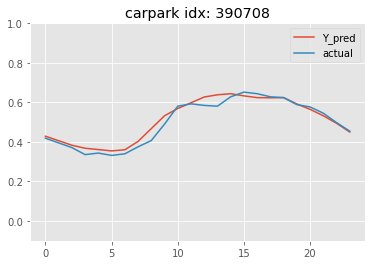

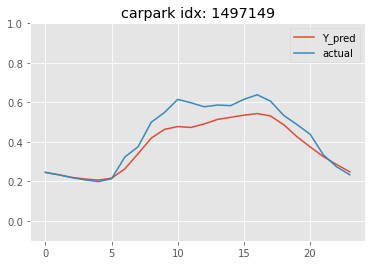

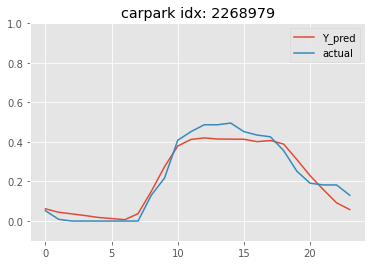

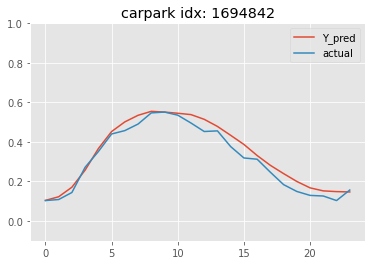

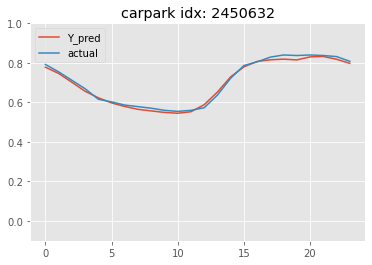

In [25]:
import random
for idx in range(5):
    idx = random.randint(0, len(testX))
    plt.figure()
    plt.ylim(-0.1,1)
    plt.title("carpark index: %s" %idx )
    plt.plot(Y_pred[idx], label='Y_pred')
    plt.plot(testY[idx], label='actual')
    plt.legend()

Text(0, 0.5, 'Actual')

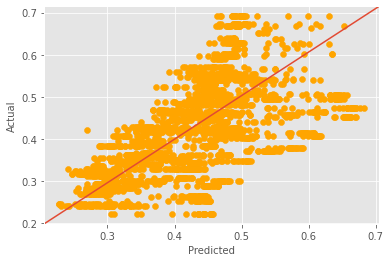

In [26]:
for idx in range(0, 100):
    plt.scatter(Y_pred[idx], testY[idx], label='Y_pred', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

# Model 2: Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(trainX, trainY)

LinearRegression()

In [28]:
# Saving the model
import pickle
filename = 'models/lr_sklearn_model.sav'
pickle.dump(model_lr, open(filename, 'wb'))
model_lr = pickle.load(open(filename, 'rb'))

In [29]:
filename = 'models/lr_sklearn_model.sav'
model_lr = pickle.load(open(filename, 'rb'))
y_pred_lr = model_lr.predict(testX)
display(trainX)

array([[0.40104167, 0.33984375, 0.328125  , ..., 0.5859375 , 0.5625    ,
        0.51953125],
       [0.33984375, 0.328125  , 0.328125  , ..., 0.5625    , 0.51953125,
        0.46875   ],
       [0.328125  , 0.328125  , 0.32421875, ..., 0.51953125, 0.46875   ,
        0.453125  ],
       ...,
       [0.43772727, 0.43772727, 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.43772727, 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ],
       [0.40625   , 0.40625   , 0.40625   , ..., 0.40625   , 0.40625   ,
        0.40625   ]])

[1291577, 583380, 1081429, 2262016, 508458, 1315399, 1623099, 2278099, 214865, 931041]


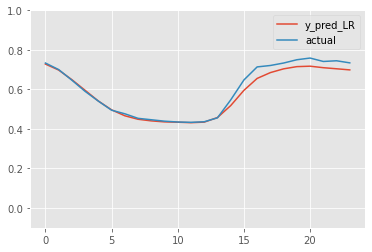

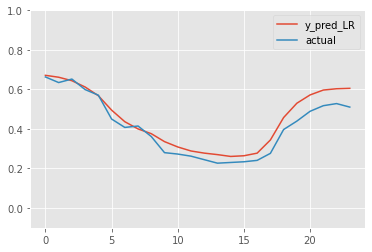

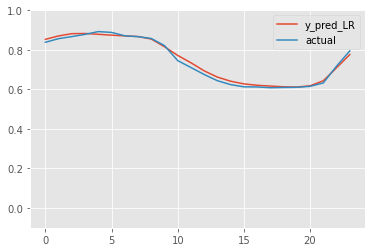

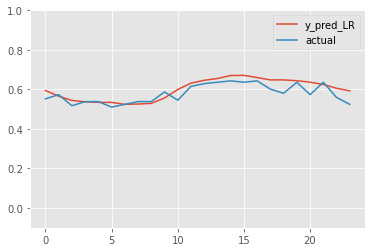

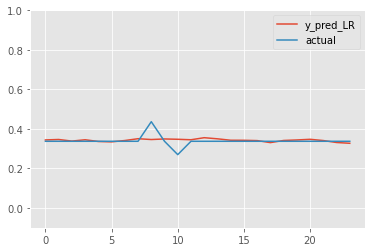

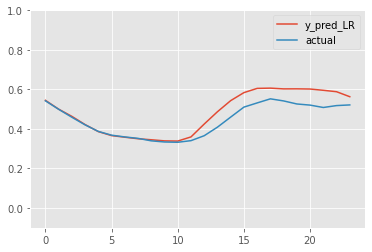

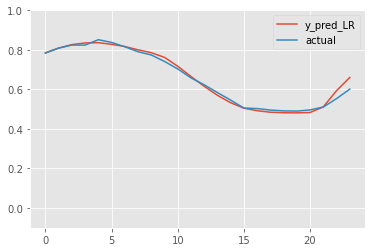

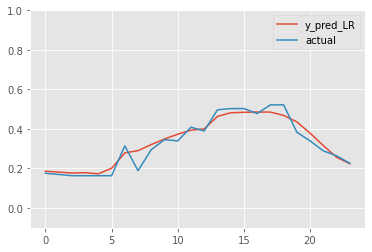

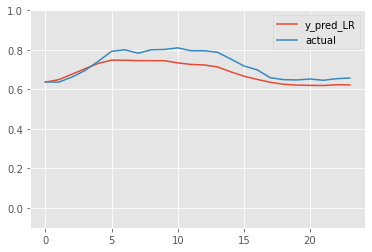

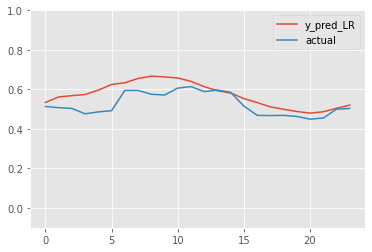

In [30]:
import random
randomList = [random.randint(0,2608130) for i in range(10)]
print(randomList)

for i in randomList:
    plt.ylim(-0.1,1)
    plt.plot(y_pred_lr[i], label='y_pred_LR')
    plt.plot(testY[i], label='actual')
    plt.legend()
    plt.show()

In [31]:
# for i in randomList:
#     lr_r2 = metrics.r2_score(testY, y_pred_lr)
#     lr_mse = metrics.mean_squared_error(testY[i], y_pred_lr[i])
#     lr_abs_error = mean_absolute_error(testY[i], y_pred_lr[i])
#     print(f"i = {i}\nModel's r2score: {lr_r2},\nMSE: {lr_mse},\Absolute Error: {lr_abs_error*100} %\n")
# for i in randomList:
lr_r2 = metrics.r2_score(testY, y_pred_lr)
lr_mse = metrics.mean_squared_error(testY, y_pred_lr)
lr_abs_error = mean_absolute_error(testY, y_pred_lr)
print(f"i = {i}\nModel's r2score: {lr_r2},\nMSE: {lr_mse},\Absolute Error: {lr_abs_error*100} %\n")

i = 931041
Model's r2score: 0.9480106634767015,
MSE: 0.005591564842698374,\Absolute Error: 4.0711792803509494 %



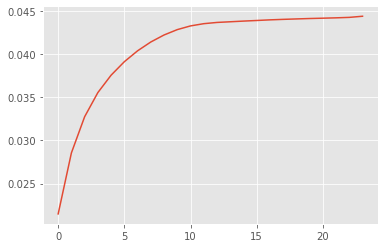

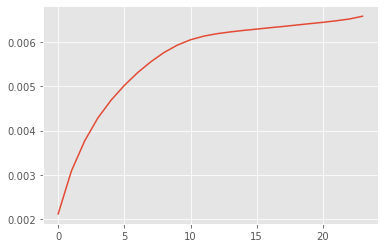

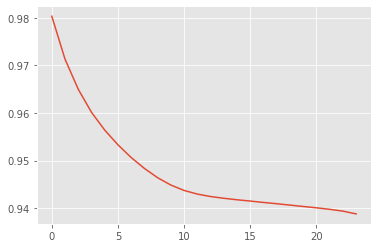

In [32]:
ae_by_hr = []
mse_by_hr = []
r2_by_hr = []
for i in range(24):
    # print("Hour{}:   MSE is {}" .format(i,mean_squared_error(testY[:,i], y_pred_lr[:,i])) )
    # print("               R2 Score is {}" .format(r2_score(testY[:,i], y_pred_lr[:,i])) )
    mse = mean_squared_error(testY[:,i], y_pred_lr[:,i])
    ae = mean_absolute_error(testY[:,i], y_pred_lr[:,i])
    r2 = r2_score(testY[:,i], y_pred_lr[:,i])
    # print("               Absolute Error is {}%" .format(100*ae))
    ae_by_hr.append(ae)
    mse_by_hr.append(mse)
    r2_by_hr.append(r2)
plt.plot(ae_by_hr)
plt.show()
plt.plot(mse_by_hr)
plt.show()
plt.plot(r2_by_hr)
plt.show()

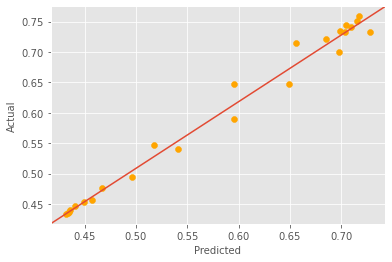

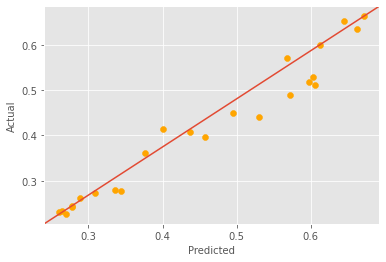

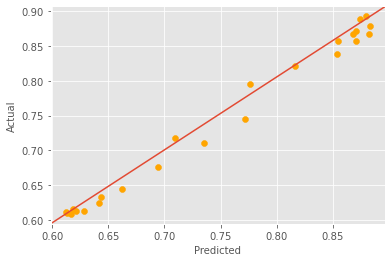

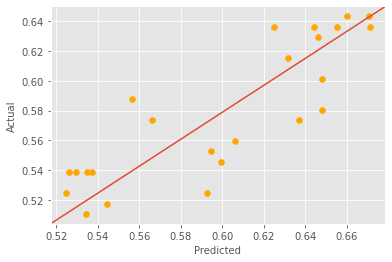

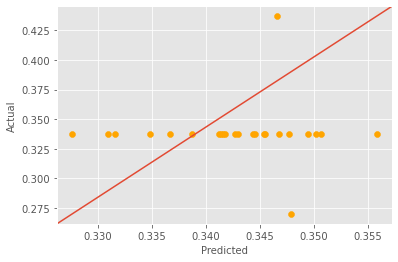

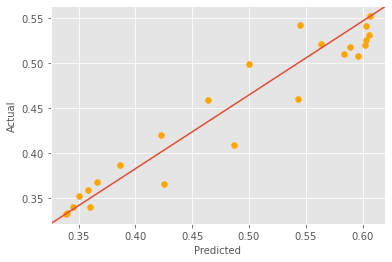

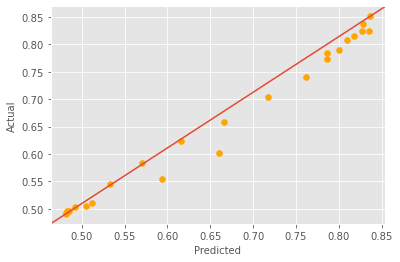

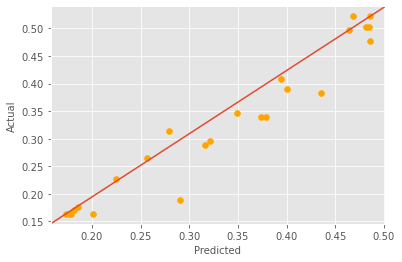

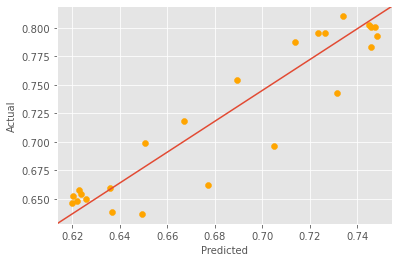

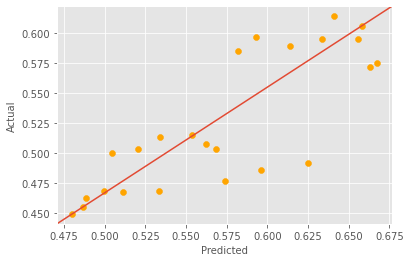

In [33]:
for i in randomList:
    plt.scatter(y_pred_lr[i], testY[i], label='Y_pred', color='orange')
    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Actual', fontsize=10)
    plt.show()

# Model 3: LSTM

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [99]:
# reshape input to be [samples, time steps, features]
trainX1 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX1 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(testX1.shape)

(2608130, 1, 192)


In [100]:
# create and fit the LSTM network
modelX = Sequential()
modelX.add(LSTM(192, input_shape=(192,1), activation="relu"))
modelX.add(Dense(24,  activation="relu"))
modelX.compile(loss='mean_squared_error', optimizer='adam')
# modelX.fit(trainX, trainY, epochs=1, batch_size=256, verbose=2)

In [101]:
# Save the model
# model.save('models/lstm_tf_model.h5')
modelX.save('models/modelXX.h5')

In [116]:
loaded = tf.keras.models.load_model('models/modelXX.h5')
ypred_lstm = loaded.predict(testX[:10].reshape(-1, 192,1))
print(ypred_lstm.shape)
#show model info
# print(modelX.summary())
# print(testX[0].shape)
# modelX(testX1[0])

2022-11-10 16:47:28.242842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
(10, 24)


In [59]:
for i in range(24):
    print("Hour{}:   MSE is {}" .format(i,mean_squared_error(testY[:,i], ypred_lstm[:,i])) )
    print("               R2 Score is {}" .format(r2_score(testY[:,i], ypred_lstm[:,i])) )
    print("               Percentage Error is {}" .format(mean_absolute_error(testY[:,i], ypred_lstm[:,i])) )

NameError: name 'ypred_lstm' is not defined

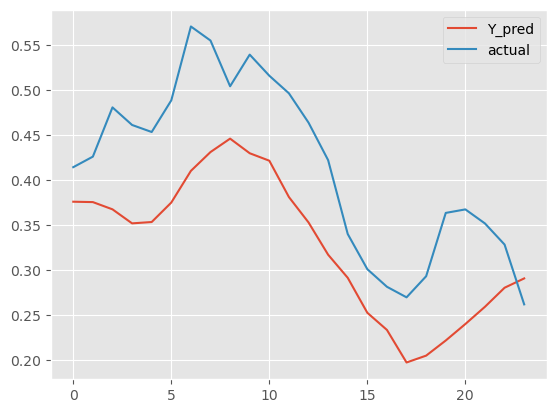

In [56]:
plt.plot(ypred_lstm[22], label='Y_pred')
plt.plot(testY[22], label='actual')
plt.legend()

Text(0, 0.5, 'Actual')

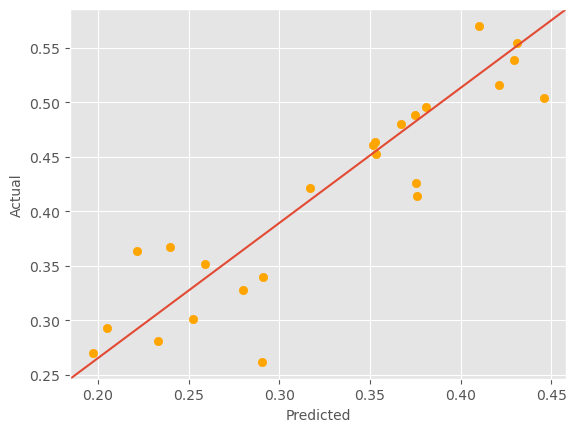

In [57]:
plt.scatter(ypred_lstm[22], testY[22], label='Y_pred', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

# Overall Flow

In [1]:
from queue import PriorityQueue
from datetime import timedelta
import pickle
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import pandas as pd
import numpy as np
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

from api_utils import getDataAtTimestamp, json2csv, postalcode2xy

### Helper methods to our app

In [2]:
def update_rencet_csv(time_now, recent):
    '''
    update recent data from API and store locally in a csv file
    '''
    range = timedelta(hours=191)
    start = time_now - range
    end = time_now
    for date in pd.date_range(start, end, freq='1h'):
        if date not in recent.index:
            recent.loc[date] = np.nan
            year, month, day, hour, mins = date.year, date.month, date.day, date.hour, date.minute+1
            try:
                raw_data = getDataAtTimestamp(str(year), str(month), str(day), str(hour), str(mins))
            except:
                continue
            raw_df = json2csv(raw_data, date)
            raw_df['lots_available'] = raw_df['lots_available'].astype(float)
            raw_df['total_lots'] = raw_df['total_lots'].astype(float)
            raw_df['available rate'] = raw_df['lots_available'] / raw_df['total_lots']
            for id in raw_df.carpark_number:
                if id in recent.columns:
                    recent.loc[date, id] = raw_df[raw_df.carpark_number == id]['available rate'].values[0]
                else:
                    print("Id not seen!")
    recent.to_csv("./data/recent.csv")

def find_nearest(x, y, location_dict) -> List[Tuple[float, str]]:
    '''
    Sort carparks by distance to the given location
    '''
    shortest = PriorityQueue()
    for key, (loc, addr) in location_dict.items():
        dist = (loc[0] - x)**2 + (loc[1] - y)**2
        shortest.put((-dist, key))
    size = shortest.qsize()
    res = [shortest.get() for i in range(size)]
    res.reverse()
    return res

def create_location_dict(loc_info: pd.DataFrame) -> Dict[str, Tuple[Tuple[float, float], str]]:
    '''
    Create a dictionary of carparks' location and address with carpark number as key
    '''
    location_dict = {}
    for row in loc_info.iterrows():
        content = row[1]
        name = content[0]
        addr = content[1]
        location = (content[2], content[3])
        location_dict[name] = (location, addr)
    return location_dict

def init():
    '''
    Initialize the app data, including recent data, location dictionary and model
    '''
    model = pickle.load(open('models/lr_sklearn_model.sav', 'rb'))
    print(colored("Model loaded!", "green"))
    recent = pd.read_csv("./data/recent.csv")
    recent['timestamp'] = pd.to_datetime(recent['timestamp'])
    recent = recent.set_index('timestamp')
    print(colored("Recent data loaded!", "green"))
    loc_info = pd.read_csv("./data/hdb-carpark-information.csv")
    location_info = create_location_dict(loc_info)
    return model, recent, location_info

def get_pred_inputs(recent: pd.DataFrame, id: str):
    '''
    Get the inputs for the model from the recent data based on the carpark number
    '''
    time_now = pd.Timestamp.now()
    time_now = time_now.floor('1h')
    range = timedelta(hours=191)
    if time_now not in recent.index:
        print(colored("Updating recent data! Please wait", "green"))
        update_rencet_csv(time_now, recent)
    most_recent = recent[id][time_now - range: time_now]
    return most_recent.values.reshape(1, -1)

def find_by_location(model,
                                    recent: pd.DataFrame,
                                    carpark_info: Dict[str, Tuple[Tuple[float, float], str]],
                                    x, y):
    """
    Find the nearest 5 carparks to the given location and predict the available rate
    """
    print(colored("Finding nearest carpark...", "green"))
    top5 = find_nearest(x, y, carpark_info)
    res = []
    for ele in top5:
        id = ele[1]
        if id not in recent.columns:
            print(f"We do not have data for the nearby carpark {id}")
            continue
        input = get_pred_inputs(recent, id)
        prediction = model.predict(input)[0]
        res.append((ele[0], ele[1], prediction))
        if (len(res) == 5):
            break
    return res

### main app flow

In [3]:
def app():
    model, recent, location_dict = init()
    print("* Welcome to the carpark availability prediction system")
    print("* Where would you like to go?")
    postal_code = input("Enter your destination postal code: ")
    x, y = postalcode2xy(postal_code)
    best_options = find_by_location(model, recent, location_dict, x, y)
    print(colored("Best options is:"))
    print(colored(f"carpark {best_options[0][1]} with distance {-best_options[0][0]}", 'yellow'))
    print(colored("Alternatives are:"))
    for ele in best_options[1:]:
        print(colored(f"carpark {ele[1]} with distance {-ele[0]}"))

    fig, axs = plt.subplots(min(5, len(best_options)+1), 1, figsize=(10, 25))
    for i in range(len(best_options)):
        axs[i].plot(best_options[i][2])
        axs[i].set_title(f"carpark at {location_dict[best_options[i][1]][1]}\n Distance {-best_options[i][0]}")
    plt.show()


### Run the app

Model loaded!
Recent data loaded!
* Welcome to the carpark availability prediction system
* Where would you like to go?
Finding nearest carpark...
Best options is:
carpark C3M with distance 427263.02948714676
Alternatives are:
carpark C3ML with distance 606583.3338573483
carpark C4M with distance 610861.7729772844
carpark C33 with distance 629935.6217044649
carpark AR2L with distance 647373.7372743348


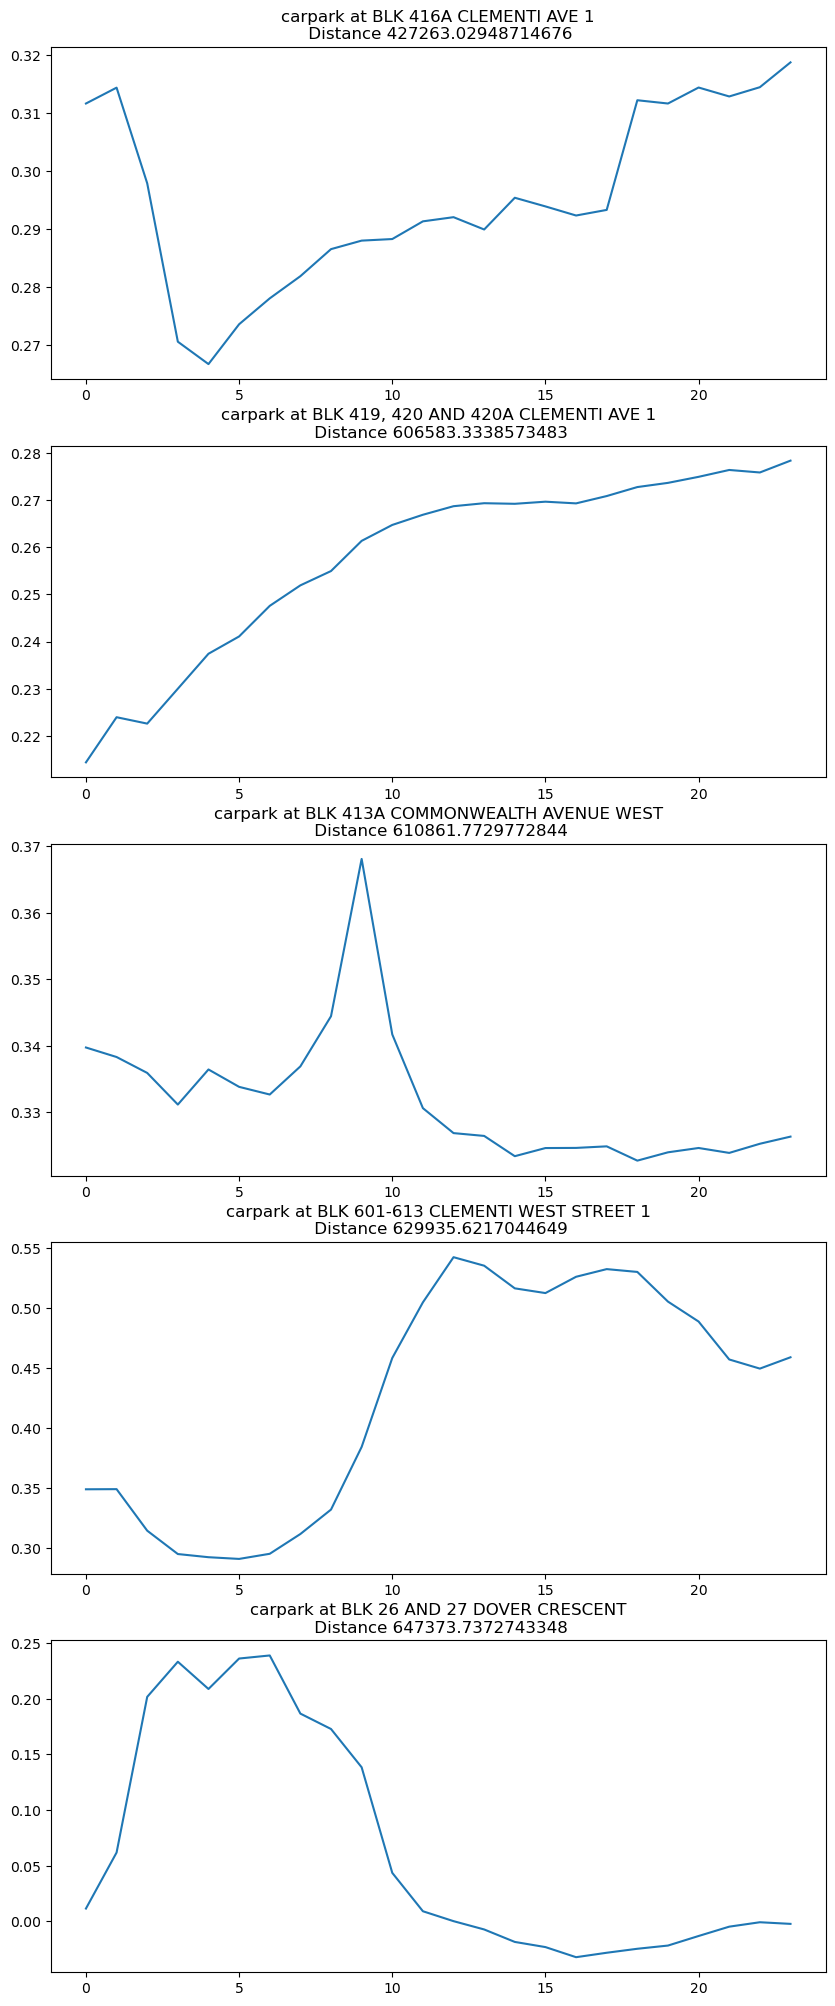

In [6]:
app()